<font size="5">Importing the Required Libraries.</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

training_data = pd.read_csv('training_set_features.csv')
labels = pd.read_csv('training_set_labels.csv')

**Separating Features**

In [2]:
numeric_columns = training_data.select_dtypes('number').columns

category_columns = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_columns = ['age_group', 'education',  'income_poverty',
        'employment_status']

**Missing Value Imputation**

In [3]:
for i, row in training_data[training_data['employment_occupation'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Unemployed")
    if conditions.any():
        training_data.loc[i, 'employment_occupation'] = 'unemployed_occupation'

for i, row in training_data[training_data['employment_industry'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Unemployed")
    if conditions.any():
        training_data.loc[i, 'employment_industry'] = 'unemployed_in_industry'

for i, row in training_data[training_data['employment_industry'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Not in Labor Force")
    if conditions.any():
        training_data.loc[i, 'employment_industry'] = 'Not_in_laborforce'

for i, row in training_data[training_data['employment_occupation'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Not in Labor Force")
    if conditions.any():
        training_data.loc[i, 'employment_occupation'] = 'Not_in_laborforce'

for i, row in training_data[training_data['employment_industry'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Employed")
    if conditions.any():
        training_data.loc[i, 'employment_industry'] = 'other_industry'
        
for i, row in training_data[training_data['employment_occupation'].isna()].iterrows():
    conditions = (training_data["employment_status"]=="Employed")
    if conditions.any():
        training_data.loc[i, 'employment_occupation'] = 'other_occupation'

In [4]:
income_poverty_nan = 'refused_or_unknown'
marital_status_nan = 'refused_or_other_category'
employment_status_nan = 'refused_or_other_category'
rent_or_own_nan = 'other_or_refused'
education_nan = 'refused_or_unknown'


training_data['income_poverty'].fillna(income_poverty_nan, inplace=True)
training_data['marital_status'].fillna(marital_status_nan, inplace=True)
training_data['employment_status'].fillna(employment_status_nan, inplace=True)
training_data['rent_or_own'].fillna(rent_or_own_nan, inplace=True)
training_data['education'].fillna(education_nan, inplace=True)

In [5]:
def missing_count(training_data): # Creating a function which returns the values which is above zero
    
    count_nan = training_data.isnull().sum()
    count_nan = count_nan[count_nan > 0].sort_values()    # To sort down the values
    
    return count_nan

In [6]:
missing_counts_as_nan = missing_count(training_data)

In [7]:
missing_counts_as_nan

behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_antiviral_meds         71
behavioral_outside_home           82
behavioral_large_gatherings       87
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_touch_face            128
behavioral_avoidance             208
household_adults                 249
household_children               249
opinion_h1n1_risk                388
opinion_h1n1_vacc_effective      391
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
health_worker                    804
child_under_6_months             820
chronic_med_condition            971
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
health_insurance               12274
dtype: int64

In [8]:
training_data[category_columns].isna().sum()

race                     0
sex                      0
marital_status           0
rent_or_own              0
hhs_geo_region           0
census_msa               0
employment_industry      0
employment_occupation    0
dtype: int64

In [9]:
training_data[ordinal_columns].isna().sum()

age_group            0
education            0
income_poverty       0
employment_status    0
dtype: int64

**Encoding the Data**

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for features in ordinal_columns:
    training_data[features] = le.fit_transform(training_data[features])

In [11]:
training_data = pd.get_dummies(training_data, columns=category_columns, drop_first=True)

In [12]:
final_training_data = pd.merge(training_data, labels, on='respondent_id')

In [13]:
final_training_data.drop('respondent_id', axis=1, inplace=True)

In [14]:
data = final_training_data.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)

In [15]:
label1 = final_training_data['h1n1_vaccine']
label2 = final_training_data['seasonal_vaccine']

**Imports for SFS**

In [21]:
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier

In [22]:
X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(data, label1, test_size=0.3, random_state=68)

**Using XGBoost as a Base Model for SFS Calculation**

In [23]:
xgb = XGBClassifier(missing = np.nan)

In [24]:
sfs = SequentialFeatureSelector(xgb, k_features=X_train_h1.shape[1], forward=True, floating=False,
                                verbose=1, scoring='roc_auc', cv=5)

In [25]:
sfs.fit(X_train_h1, y_train_h1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   29.7s finished
Features: 1/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:  1.3min finished
Features: 2/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  2.0min finished
Features: 3/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  2.6min finished
Features: 4/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  2.7min finished
Features: 5/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  2.9min finished
Features: 6/90[Parallel(

[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  3.7min finished
Features: 50/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.6min finished
Features: 51/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  3.8min finished
Features: 52/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  3.5min finished
Features: 53/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  3.5min finished
Features: 54/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.4min finished
Features: 55/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Par

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                              

In [26]:
h1n1_sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
h1n1_sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(16,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(opinion_h1n1_risk,)",0.005078,0.003951,0.001975
2,"(9, 16)","[0.7925673159437187, 0.7833433373349339, 0.783...",0.78679,"(doctor_recc_h1n1, opinion_h1n1_risk)",0.008038,0.006254,0.003127
3,"(9, 14, 16)","[0.8311918013326414, 0.8251198351681098, 0.814...",0.825234,"(doctor_recc_h1n1, health_insurance, opinion_h...",0.008998,0.007001,0.0035
4,"(9, 14, 15, 16)","[0.8421455287317239, 0.8435012302793459, 0.834...",0.841401,"(doctor_recc_h1n1, health_insurance, opinion_h...",0.008801,0.006848,0.003424
5,"(9, 13, 14, 15, 16)","[0.8457214951694094, 0.8473806543894153, 0.838...",0.84613,"(doctor_recc_h1n1, health_worker, health_insur...",0.01033,0.008037,0.004019
...,...,...,...,...,...,...,...
86,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[0.85173406143717, 0.8520884949724571, 0.84922...",0.852278,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.005621,0.004373,0.002187
87,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[0.8496036077954151, 0.8506598384034465, 0.849...",0.85263,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.007504,0.005838,0.002919
88,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[0.8516045298557512, 0.8494551011894118, 0.842...",0.85179,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.009294,0.007231,0.003616
89,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[0.8467760697220781, 0.8504899832273336, 0.845...",0.850836,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.009566,0.007443,0.003722


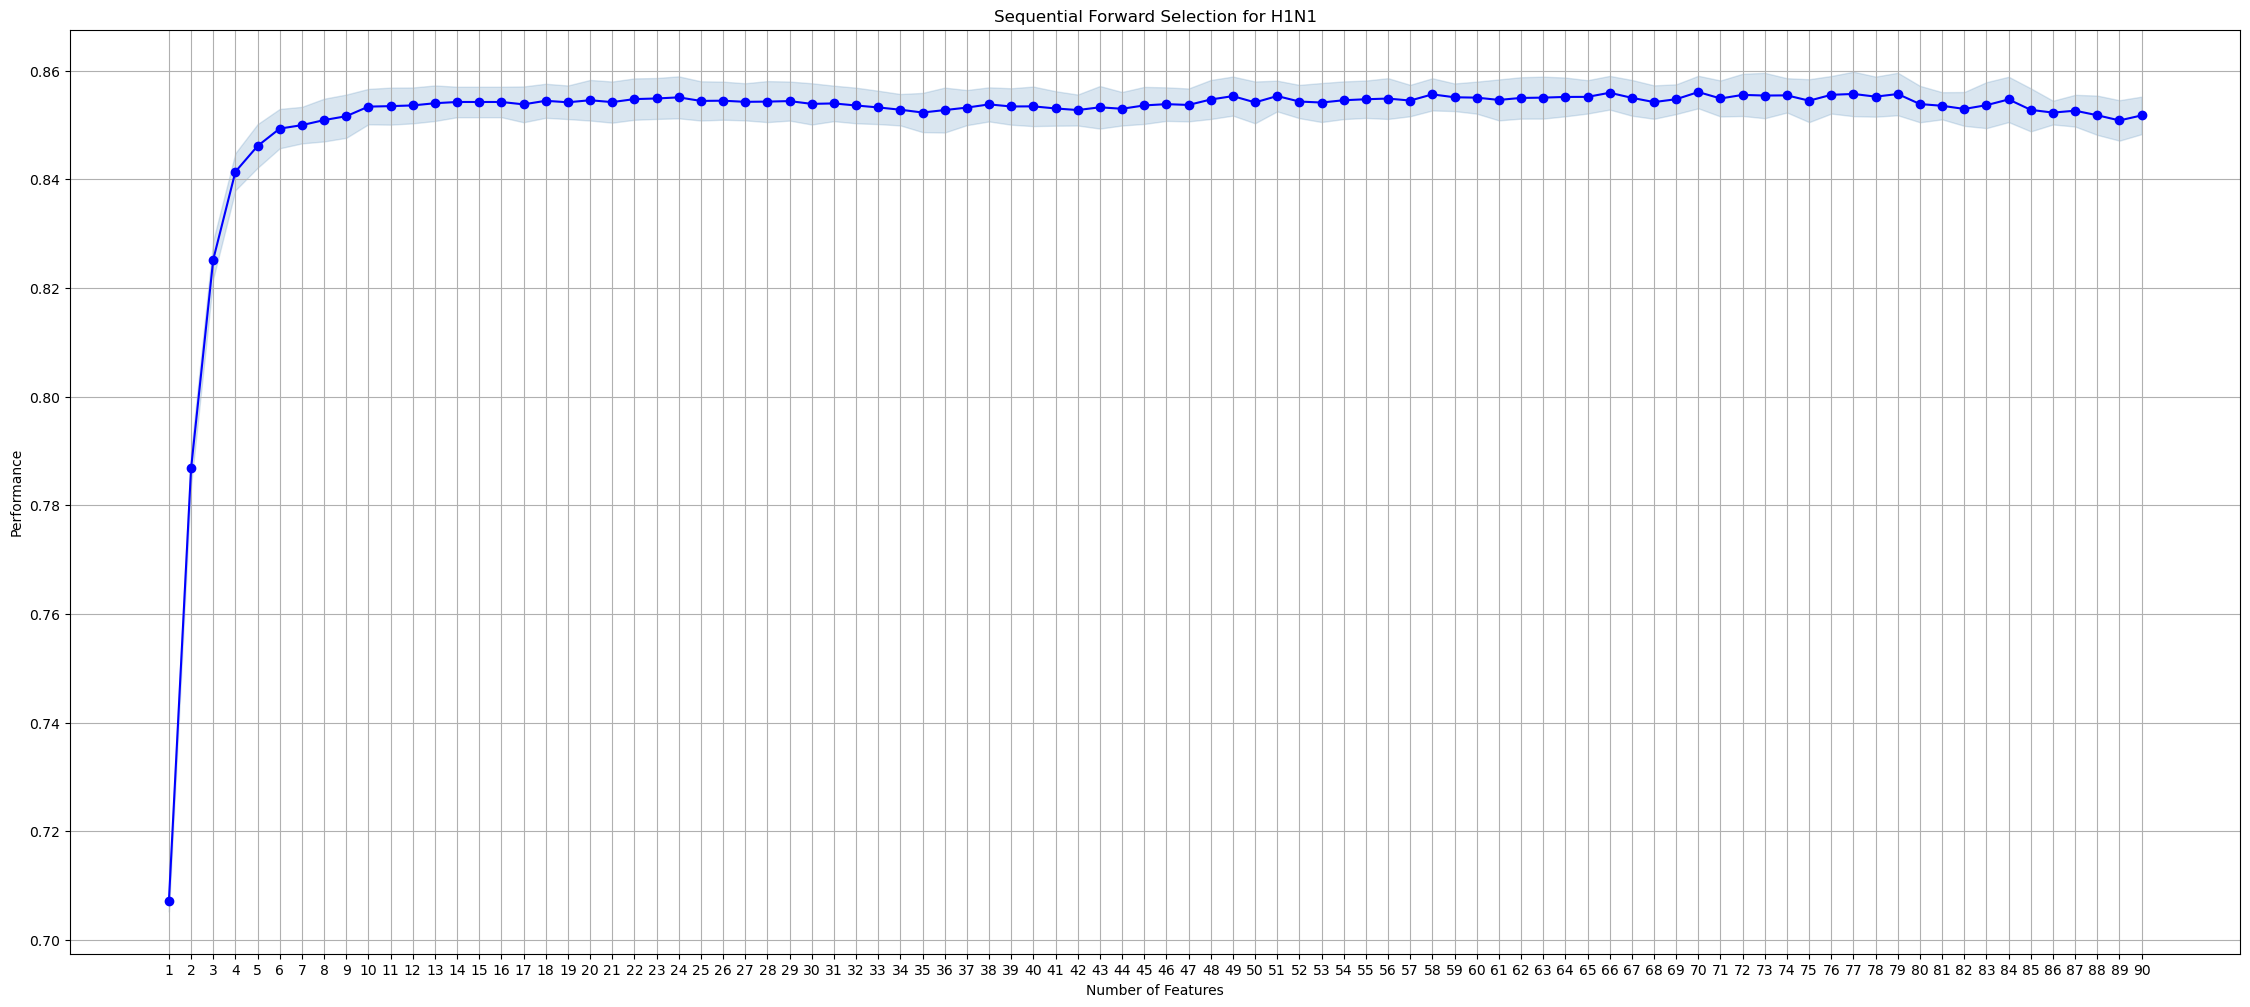

In [50]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(28,12))

plt.title('Sequential Forward Selection for H1N1')
plt.grid()
plt.show()

In [51]:
print(h1n1_sfs_df.loc[77, 'feature_idx'])

(0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89)


In [52]:
h1_column_names = X_train_h1.columns

In [53]:
final_h1_columns = [h1_column_names[i] for i in 
                     list((0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28,
                           29, 30, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 
                           57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 78, 79, 80,
                           81, 82, 83, 84, 85, 86, 87, 88, 89))]

In [54]:
len(final_h1_columns)

77

In [55]:
print(final_h1_columns)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_outside_home', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'household_adults', 'race_Hispanic', 'race_Other or Multiple', 'race_White', 'sex_Male', 'marital_status_Not Married', 'marital_status_refused_or_other_category', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_lzgpxyit', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun', 'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy', 'employment_industry_dotnnunm', 'employment_industry_fcxhlnwr', 'employment_industry_haxffmxo', 'employ

In [56]:
X_train_seas, X_test_seas, y_train_seas, y_test_seas = train_test_split(data, label2, \
                                                                        test_size=0.3, random_state=68)

In [57]:
sfs_2 = SequentialFeatureSelector(xgb, k_features=X_train_seas.shape[1], forward=True, floating=False,
                                verbose=1, scoring='roc_auc', cv=5)

In [58]:
sfs_2.fit(X_train_seas, y_train_seas)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   28.9s finished
Features: 1/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:  1.1min finished
Features: 2/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  1.8min finished
Features: 3/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  2.3min finished
Features: 4/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  2.5min finished
Features: 5/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  2.5min finished
Features: 6/90[Parallel(

[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  5.2min finished
Features: 50/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.2min finished
Features: 51/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  4.6min finished
Features: 52/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  4.6min finished
Features: 53/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  4.5min finished
Features: 54/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.6min finished
Features: 55/90[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Par

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                              

In [59]:
seas_sfs_df = pd.DataFrame.from_dict(sfs_2.get_metric_dict()).T

In [60]:
seas_sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(19,)","[0.704703565267395, 0.7271142898217366, 0.7135...",0.714989,"(opinion_seas_risk,)",0.009434,0.00734,0.00367
2,"(19, 21)","[0.7679320011500862, 0.7837525876940771, 0.778...",0.776593,"(opinion_seas_risk, age_group)",0.00664,0.005167,0.002583
3,"(10, 19, 21)","[0.8102540253018978, 0.8121117021276596, 0.808...",0.810975,"(doctor_recc_seasonal, opinion_seas_risk, age_...",0.002687,0.002091,0.001045
4,"(10, 18, 19, 21)","[0.8348911730879816, 0.8337091719378954, 0.825...",0.831985,"(doctor_recc_seasonal, opinion_seas_vacc_effec...",0.004365,0.003396,0.001698
5,"(10, 18, 19, 21, 50)","[0.8370631109833238, 0.8362895342150662, 0.829...",0.835008,"(doctor_recc_seasonal, opinion_seas_vacc_effec...",0.003408,0.002652,0.001326
...,...,...,...,...,...,...,...
86,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8479235192639447, 0.8574065554916619, 0.840...",0.851087,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.007937,0.006175,0.003088
87,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8488812535940194, 0.8564031052328924, 0.842...",0.850796,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.006178,0.004807,0.002404
88,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8499194939620472, 0.8550296147211041, 0.842...",0.850727,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.005963,0.004639,0.00232
89,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8473435882691203, 0.8550402530189765, 0.841...",0.849862,"(h1n1_concern, h1n1_knowledge, behavioral_anti...",0.006073,0.004725,0.002363


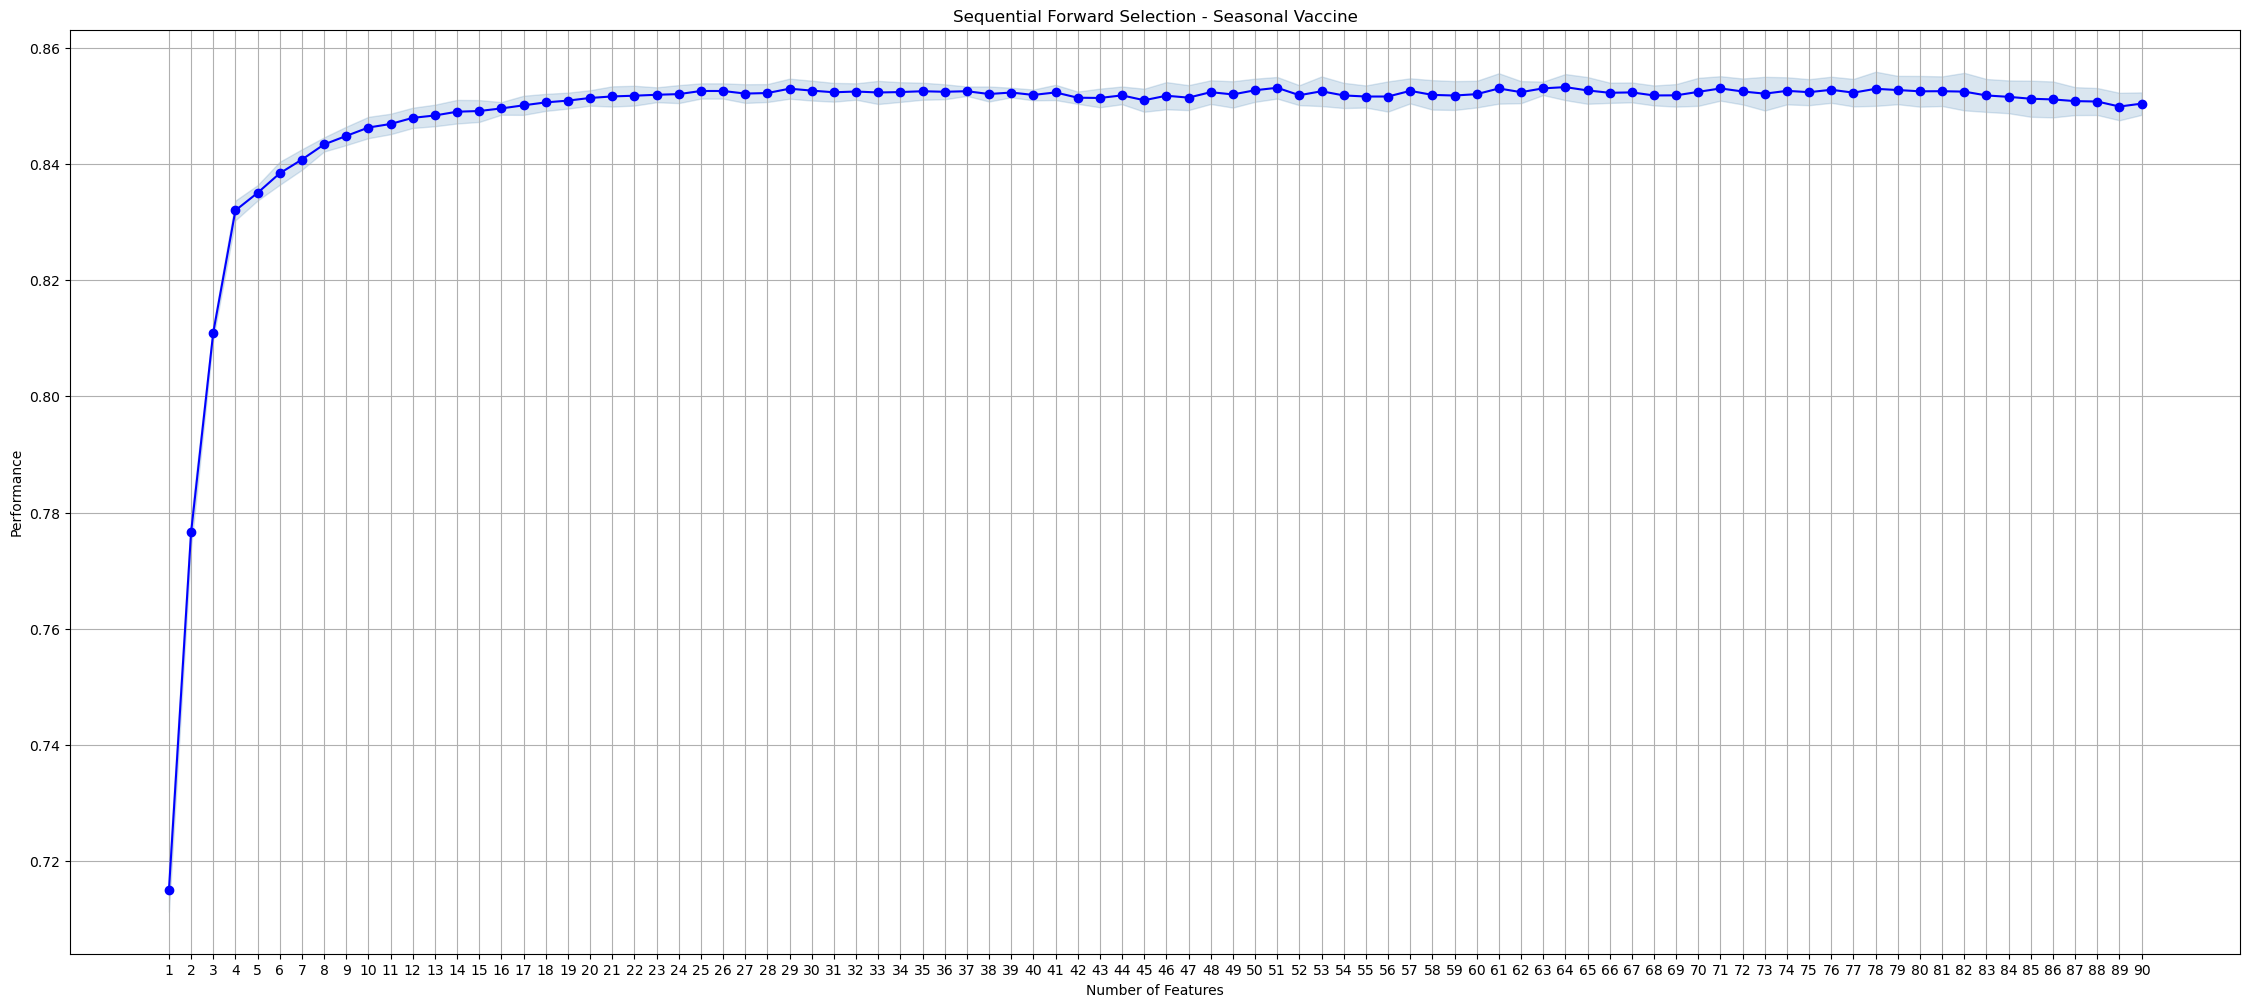

In [61]:
fig = plot_sfs(sfs_2.get_metric_dict(), kind='std_err', figsize=(28,12))

plt.title('Sequential Forward Selection - Seasonal Vaccine')
plt.grid()
plt.show()

In [64]:
seas_column_names = X_train_seas.columns

In [65]:
print(seas_sfs_df.loc[61, 'feature_idx'])

(1, 2, 4, 5, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 31, 32, 33, 34, 36, 37, 41, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 81, 83, 84, 85, 86, 87, 89)


In [66]:
final_seas_columns = [seas_column_names[i] for i in 
                     list((1, 2, 4, 5, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 31, 32,
                           33, 34, 36, 37, 41, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 
                           64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 81, 83, 84, 85, 86, 87, 89))]

In [67]:
len(final_seas_columns) #78

61

In [68]:
print(final_seas_columns)

['h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'employment_status', 'race_Hispanic', 'marital_status_Not Married', 'marital_status_refused_or_other_category', 'rent_or_own_Rent', 'rent_or_own_other_refused', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_mlyzmhmf', 'census_msa_Non-MSA', 'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy', 'employment_industry_haxffmxo', 'employment_industry_ldnlellj', 'employment_industry_mcubkhph', 'employment_industry_mfikgejo', 'employment_industry_msuufmds', 'employment_industry_nduyfdeo', 'employment_industry_phxvnwax', 'employment_industry_qnlwzans'

In [69]:
data_h1 = data[['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_outside_home', 'doctor_recc_h1n1',
                'doctor_recc_seasonal', 'child_under_6_months', 'health_worker', 'health_insurance', 
                'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 
                'age_group', 'education', 'income_poverty', 'household_adults', 'race_Hispanic', 
                'race_Other or Multiple', 'race_White', 'sex_Male', 'marital_status_Not Married',
                'marital_status_refused_or_other_category', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 
                'hhs_geo_region_lzgpxyit', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun', 
                'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'employment_industry_atmlpfrs', 
                'employment_industry_cfqqtusy', 'employment_industry_dotnnunm', 'employment_industry_fcxhlnwr', 
                'employment_industry_haxffmxo', 'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
                'employment_industry_mfikgejo', 'employment_industry_msuufmds', 'employment_industry_nduyfdeo', 
                'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn', 'employment_industry_qnlwzans',
                'employment_industry_rucpziij', 'employment_industry_saaquncn', 
                'employment_industry_unemployed_in_industry', 'employment_industry_vjjrobsf',
                'employment_industry_wlfvacwt', 'employment_industry_wxleyezf', 'employment_industry_xicduogh', 
                'employment_industry_xqicxuve', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 
                'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_haliazsg',
                'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment_occupation_kldqjyjy',
                'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik', 'employment_occupation_qxajmpny',
                'employment_occupation_rcertsgn', 'employment_occupation_tfqavkke', 'employment_occupation_ukymxvdu', 
                'employment_occupation_unemployed_occupation', 'employment_occupation_uqqtjvyb',
                'employment_occupation_vlluhbov', 'employment_occupation_xgwztkwe', 'employment_occupation_xqwwgdyp',
                'employment_occupation_xtkaffoo', 'employment_occupation_xzmlyyjv']]

In [70]:
data_seas = data[['h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_wash_hands',
                  'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 
                  'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                  'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'employment_status', 
                  'race_Hispanic', 'marital_status_Not Married', 'marital_status_refused_or_other_category', 
                  'rent_or_own_Rent', 'rent_or_own_other_refused', 'hhs_geo_region_dqpwygqj', 
                  'hhs_geo_region_fpwskwrf', 'hhs_geo_region_mlyzmhmf', 'census_msa_Non-MSA', 
                  'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy', 'employment_industry_haxffmxo',
                  'employment_industry_ldnlellj', 'employment_industry_mcubkhph', 'employment_industry_mfikgejo', 
                  'employment_industry_msuufmds', 'employment_industry_nduyfdeo', 'employment_industry_phxvnwax',
                  'employment_industry_qnlwzans', 'employment_industry_rucpziij', 'employment_industry_saaquncn', 
                  'employment_industry_vjjrobsf', 'employment_industry_wlfvacwt', 'employment_industry_wxleyezf',
                  'employment_industry_xicduogh', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 
                  'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 
                  'employment_occupation_emcorrxb','employment_occupation_haliazsg', 
                  'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew',
                  'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik',
                  'employment_occupation_tfqavkke', 'employment_occupation_unemployed_occupation',
                  'employment_occupation_uqqtjvyb','employment_occupation_vlluhbov', 
                  'employment_occupation_xgwztkwe', 'employment_occupation_xqwwgdyp',
                  'employment_occupation_xzmlyyjv']]

In [72]:
len(data_h1.columns)

77

In [73]:
len(data_seas.columns)

61

In [74]:
import optuna
from optuna import visualization
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [75]:
X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(data_h1, label1, test_size=0.2, random_state=101)

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 8),
        'gamma': trial.suggest_float('gamma',1e-8, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
    }
    
    xgb = XGBClassifier(**param, missing= np.nan)
    
#     print("X_train shape:", X_train.shape)
#     print("y_train shape:", y_train.shape)
    
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(xgb, data_h1, label1, cv=5, scoring='roc_auc')
    AUC = np.mean(scores).max() 
    return AUC

In [76]:
study1 = optuna.create_study(direction='maximize', sampler=TPESampler())
study1.optimize(objective, n_trials=120, show_progress_bar=True)

[I 2023-05-14 19:45:39,008] A new study created in memory with name: no-name-dfd68ab5-e6ec-4466-b433-5dc32890bbcb
/Users/karthikeyan/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/120 [00:00<?, ?it/s]

[I 2023-05-14 19:45:56,119] Trial 0 finished with value: 0.8226902528205251 and parameters: {'n_estimators': 460, 'max_depth': 3, 'reg_alpha': 0.9452400919215485, 'reg_lambda': 0.9004925579424771, 'min_child_weight': 7, 'gamma': 0.07722025094480649, 'learning_rate': 0.9720324289109239, 'colsample_bytree': 0.5385603928689817, 'subsample': 0.543196163509702}. Best is trial 0 with value: 0.8226902528205251.
[I 2023-05-14 19:46:07,388] Trial 1 finished with value: 0.8127517484114254 and parameters: {'n_estimators': 209, 'max_depth': 5, 'reg_alpha': 0.5209266862748118, 'reg_lambda': 0.2651946481594423, 'min_child_weight': 1, 'gamma': 0.4995583788973864, 'learning_rate': 0.8068342210867918, 'colsample_bytree': 0.5150328583888656, 'subsample': 0.6383360633890387}. Best is trial 0 with value: 0.8226902528205251.
[I 2023-05-14 19:46:20,486] Trial 2 finished with value: 0.7907644090201489 and parameters: {'n_estimators': 315, 'max_depth': 4, 'reg_alpha': 0.41935936632933435, 'reg_lambda': 0.0872

[I 2023-05-14 19:54:20,952] Trial 20 finished with value: 0.8551982786200323 and parameters: {'n_estimators': 457, 'max_depth': 7, 'reg_alpha': 0.9014789566141964, 'reg_lambda': 0.12378601684135193, 'min_child_weight': 7, 'gamma': 0.017914030013421955, 'learning_rate': 0.14480866126636677, 'colsample_bytree': 0.390681562721627, 'subsample': 0.718063346925101}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 19:54:49,558] Trial 21 finished with value: 0.8721149755655251 and parameters: {'n_estimators': 378, 'max_depth': 6, 'reg_alpha': 0.9465165825622684, 'reg_lambda': 0.452806681753423, 'min_child_weight': 6, 'gamma': 0.26885938070565163, 'learning_rate': 0.022736062018413994, 'colsample_bytree': 0.4809796606694571, 'subsample': 0.5747705931393474}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 19:55:20,531] Trial 22 finished with value: 0.869492952999084 and parameters: {'n_estimators': 370, 'max_depth': 7, 'reg_alpha': 0.897422719258824, 'reg_lambda': 

[I 2023-05-14 20:02:18,095] Trial 40 finished with value: 0.8615613752633224 and parameters: {'n_estimators': 278, 'max_depth': 6, 'reg_alpha': 0.8154633028730458, 'reg_lambda': 0.48496604739740884, 'min_child_weight': 7, 'gamma': 0.04136854574366769, 'learning_rate': 0.15610985249598683, 'colsample_bytree': 0.5318287440159177, 'subsample': 0.6849329333182737}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 20:02:43,126] Trial 41 finished with value: 0.8679853141948026 and parameters: {'n_estimators': 409, 'max_depth': 5, 'reg_alpha': 0.9374234883204331, 'reg_lambda': 0.4316805811430724, 'min_child_weight': 7, 'gamma': 0.13060675067773475, 'learning_rate': 0.10263404264694496, 'colsample_bytree': 0.47871109073387463, 'subsample': 0.6627984272316881}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 20:03:13,335] Trial 42 finished with value: 0.8713907500145709 and parameters: {'n_estimators': 499, 'max_depth': 5, 'reg_alpha': 0.8509560860373073, 'reg_lambd

[I 2023-05-14 20:10:07,649] Trial 60 finished with value: 0.8703249643391082 and parameters: {'n_estimators': 336, 'max_depth': 8, 'reg_alpha': 0.9082647522706919, 'reg_lambda': 0.4600820674033802, 'min_child_weight': 4, 'gamma': 0.243775338455054, 'learning_rate': 0.05083338272666531, 'colsample_bytree': 0.3623723499903612, 'subsample': 0.4724223195061705}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 20:10:30,559] Trial 61 finished with value: 0.8698096788435802 and parameters: {'n_estimators': 354, 'max_depth': 6, 'reg_alpha': 0.9613204571497713, 'reg_lambda': 0.5134862359845923, 'min_child_weight': 6, 'gamma': 0.18767143910869183, 'learning_rate': 0.06945720457139422, 'colsample_bytree': 0.39170546603441164, 'subsample': 0.6021257511290294}. Best is trial 11 with value: 0.8724231355240054.
[I 2023-05-14 20:10:52,050] Trial 62 finished with value: 0.8716850794589414 and parameters: {'n_estimators': 314, 'max_depth': 6, 'reg_alpha': 0.8740253597708204, 'reg_lambda':

[I 2023-05-14 20:18:12,539] Trial 80 finished with value: 0.8727463990260809 and parameters: {'n_estimators': 446, 'max_depth': 6, 'reg_alpha': 0.915683688202254, 'reg_lambda': 0.31334741303605357, 'min_child_weight': 6, 'gamma': 0.22429294648503934, 'learning_rate': 0.030618678740731226, 'colsample_bytree': 0.3643474858944649, 'subsample': 0.6783493117610017}. Best is trial 80 with value: 0.8727463990260809.
[I 2023-05-14 20:18:41,789] Trial 81 finished with value: 0.8722690233640418 and parameters: {'n_estimators': 446, 'max_depth': 6, 'reg_alpha': 0.9136689675305364, 'reg_lambda': 0.3431761496781834, 'min_child_weight': 6, 'gamma': 0.2842889307825871, 'learning_rate': 0.0364742746543211, 'colsample_bytree': 0.344176063573904, 'subsample': 0.683959244790534}. Best is trial 80 with value: 0.8727463990260809.
[I 2023-05-14 20:19:11,439] Trial 82 finished with value: 0.872588484613947 and parameters: {'n_estimators': 447, 'max_depth': 6, 'reg_alpha': 0.9778853218093838, 'reg_lambda': 0.

[I 2023-05-14 20:27:25,355] Trial 100 finished with value: 0.8696995126211025 and parameters: {'n_estimators': 417, 'max_depth': 7, 'reg_alpha': 0.953095805126904, 'reg_lambda': 0.22628175771170594, 'min_child_weight': 2, 'gamma': 0.31636131069051276, 'learning_rate': 0.012088810857114128, 'colsample_bytree': 0.34041994399960884, 'subsample': 0.7111243468609243}. Best is trial 80 with value: 0.8727463990260809.
[I 2023-05-14 20:27:55,151] Trial 101 finished with value: 0.8725810557804932 and parameters: {'n_estimators': 459, 'max_depth': 6, 'reg_alpha': 0.924856481692854, 'reg_lambda': 0.29237142293491225, 'min_child_weight': 3, 'gamma': 0.27432858972372887, 'learning_rate': 0.028723518899979577, 'colsample_bytree': 0.3939326781312376, 'subsample': 0.6617288552690209}. Best is trial 80 with value: 0.8727463990260809.
[I 2023-05-14 20:28:24,020] Trial 102 finished with value: 0.8687801081480826 and parameters: {'n_estimators': 459, 'max_depth': 6, 'reg_alpha': 0.9774508850337651, 'reg_l

In [77]:
study1.best_trial

FrozenTrial(number=80, state=TrialState.COMPLETE, values=[0.8727463990260809], datetime_start=datetime.datetime(2023, 5, 14, 20, 17, 43, 976277), datetime_complete=datetime.datetime(2023, 5, 14, 20, 18, 12, 538933), params={'n_estimators': 446, 'max_depth': 6, 'reg_alpha': 0.915683688202254, 'reg_lambda': 0.31334741303605357, 'min_child_weight': 6, 'gamma': 0.22429294648503934, 'learning_rate': 0.030618678740731226, 'colsample_bytree': 0.3643474858944649, 'subsample': 0.6783493117610017}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'reg_lambda': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'min_child_weight': IntDistribution(high=8, log=False, low=0, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'learni

In [78]:
study1.best_value

0.8727463990260809

In [79]:
study1.best_params

{'n_estimators': 446,
 'max_depth': 6,
 'reg_alpha': 0.915683688202254,
 'reg_lambda': 0.31334741303605357,
 'min_child_weight': 6,
 'gamma': 0.22429294648503934,
 'learning_rate': 0.030618678740731226,
 'colsample_bytree': 0.3643474858944649,
 'subsample': 0.6783493117610017}

In [80]:
param_h1 = study1.best_params

In [81]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(data_seas, label2, test_size=0.2, random_state=101)

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 8),
        'gamma': trial.suggest_float('gamma',1e-8, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
    }
    
    xgb = XGBClassifier(**param, missing= np.nan)
    
#     print("X_train shape:", X_train.shape)
#     print("y_train shape:", y_train.shape)
    
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(xgb, data_seas, label2, cv=5, scoring='roc_auc')
    AUC = np.mean(scores).max() 
    return AUC

In [82]:
study2 = optuna.create_study(direction='maximize', sampler=TPESampler())
study2.optimize(objective, n_trials=120, show_progress_bar=True)

[I 2023-05-14 20:40:27,594] A new study created in memory with name: no-name-ecf01fe8-1844-49b7-aff8-2e5ae734116f
/Users/karthikeyan/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/120 [00:00<?, ?it/s]

[I 2023-05-14 20:40:48,475] Trial 0 finished with value: 0.7808155757697869 and parameters: {'n_estimators': 379, 'max_depth': 7, 'reg_alpha': 0.10015189065049622, 'reg_lambda': 0.6699051138119736, 'min_child_weight': 1, 'gamma': 0.6637090985944448, 'learning_rate': 0.7363320326030119, 'colsample_bytree': 0.3915332001626675, 'subsample': 0.42507320341638766}. Best is trial 0 with value: 0.7808155757697869.
[I 2023-05-14 20:41:14,134] Trial 1 finished with value: 0.8212295904506799 and parameters: {'n_estimators': 323, 'max_depth': 8, 'reg_alpha': 0.405291479075366, 'reg_lambda': 0.6911213386870216, 'min_child_weight': 5, 'gamma': 0.6305710388116685, 'learning_rate': 0.3639792426210921, 'colsample_bytree': 0.5537017907151911, 'subsample': 0.5767489417006199}. Best is trial 1 with value: 0.8212295904506799.
[I 2023-05-14 20:41:20,600] Trial 2 finished with value: 0.8485852053141256 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 0.5544456465400988, 'reg_lambda': 0.1048

[I 2023-05-14 20:48:22,637] Trial 20 finished with value: 0.8532702958897115 and parameters: {'n_estimators': 467, 'max_depth': 7, 'reg_alpha': 0.7351499826194628, 'reg_lambda': 0.422376687742663, 'min_child_weight': 8, 'gamma': 0.15068596963664097, 'learning_rate': 0.11330378386792023, 'colsample_bytree': 0.4775594671891297, 'subsample': 0.8360524561056124}. Best is trial 12 with value: 0.8642992529152999.
[I 2023-05-14 20:48:53,213] Trial 21 finished with value: 0.8615656364773085 and parameters: {'n_estimators': 459, 'max_depth': 7, 'reg_alpha': 0.8441794230840991, 'reg_lambda': 0.3214149825169222, 'min_child_weight': 8, 'gamma': 0.23681999117973201, 'learning_rate': 0.010275703209866847, 'colsample_bytree': 0.3014767111595803, 'subsample': 0.8866450634540658}. Best is trial 12 with value: 0.8642992529152999.
[I 2023-05-14 20:49:25,345] Trial 22 finished with value: 0.8637232861410433 and parameters: {'n_estimators': 500, 'max_depth': 6, 'reg_alpha': 0.9966023591649851, 'reg_lambda'

[I 2023-05-14 20:56:17,584] Trial 40 finished with value: 0.8637905978477942 and parameters: {'n_estimators': 443, 'max_depth': 4, 'reg_alpha': 0.7234750673793251, 'reg_lambda': 0.08237900976804899, 'min_child_weight': 3, 'gamma': 0.3154636600497686, 'learning_rate': 0.06621014645141433, 'colsample_bytree': 0.3944365428111357, 'subsample': 0.6489406283513098}. Best is trial 12 with value: 0.8642992529152999.
[I 2023-05-14 20:56:40,294] Trial 41 finished with value: 0.8643581225627738 and parameters: {'n_estimators': 446, 'max_depth': 4, 'reg_alpha': 0.7206137061291473, 'reg_lambda': 0.009210558284682369, 'min_child_weight': 3, 'gamma': 0.31785339133233587, 'learning_rate': 0.06423248879619561, 'colsample_bytree': 0.3855261838655738, 'subsample': 0.562956322592604}. Best is trial 41 with value: 0.8643581225627738.
[I 2023-05-14 20:57:03,391] Trial 42 finished with value: 0.8635399527391912 and parameters: {'n_estimators': 443, 'max_depth': 4, 'reg_alpha': 0.7266203131761696, 'reg_lambda

[I 2023-05-14 21:02:48,834] Trial 60 finished with value: 0.8541337564757011 and parameters: {'n_estimators': 482, 'max_depth': 5, 'reg_alpha': 0.6280281762943611, 'reg_lambda': 0.12337525010790895, 'min_child_weight': 5, 'gamma': 0.03208684128378328, 'learning_rate': 0.1697455487579929, 'colsample_bytree': 0.3240853390885731, 'subsample': 0.5821453281336428}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:03:18,744] Trial 61 finished with value: 0.8641830239611862 and parameters: {'n_estimators': 425, 'max_depth': 5, 'reg_alpha': 0.694655840488776, 'reg_lambda': 0.217496999254345, 'min_child_weight': 3, 'gamma': 0.577914298956804, 'learning_rate': 0.034631095742312074, 'colsample_bytree': 0.4411809529249875, 'subsample': 0.6153674030146911}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:03:46,869] Trial 62 finished with value: 0.8641361475637069 and parameters: {'n_estimators': 445, 'max_depth': 5, 'reg_alpha': 0.7528054710845987, 'reg_lambda': 0

[I 2023-05-14 21:13:03,925] Trial 80 finished with value: 0.8603631235973935 and parameters: {'n_estimators': 387, 'max_depth': 5, 'reg_alpha': 0.8409079983254432, 'reg_lambda': 0.30459451996195286, 'min_child_weight': 5, 'gamma': 0.5913462337294948, 'learning_rate': 0.12721771163436812, 'colsample_bytree': 0.30065340828586207, 'subsample': 0.6318913796641032}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:13:34,795] Trial 81 finished with value: 0.8639092425636056 and parameters: {'n_estimators': 496, 'max_depth': 5, 'reg_alpha': 0.8691886451619738, 'reg_lambda': 0.07270544433307799, 'min_child_weight': 4, 'gamma': 0.49495553798497455, 'learning_rate': 0.046627942328358915, 'colsample_bytree': 0.35841505733148793, 'subsample': 0.5435062336559917}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:14:06,359] Trial 82 finished with value: 0.8640746363655806 and parameters: {'n_estimators': 474, 'max_depth': 5, 'reg_alpha': 0.8127802833136838, 'reg_lam

[I 2023-05-14 21:22:25,049] Trial 100 finished with value: 0.8600354159462535 and parameters: {'n_estimators': 401, 'max_depth': 9, 'reg_alpha': 0.6149710620265055, 'reg_lambda': 0.07111696558173763, 'min_child_weight': 3, 'gamma': 0.6124340841215845, 'learning_rate': 0.048805228513699464, 'colsample_bytree': 0.34480836507460155, 'subsample': 0.5499372744492211}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:22:55,941] Trial 101 finished with value: 0.8637284184022003 and parameters: {'n_estimators': 498, 'max_depth': 5, 'reg_alpha': 0.8821468537982119, 'reg_lambda': 0.025818394628510544, 'min_child_weight': 4, 'gamma': 0.4936972529130179, 'learning_rate': 0.05409544356371171, 'colsample_bytree': 0.3559306902438353, 'subsample': 0.5468332161886242}. Best is trial 44 with value: 0.8644082386209366.
[I 2023-05-14 21:23:26,400] Trial 102 finished with value: 0.864480884789749 and parameters: {'n_estimators': 479, 'max_depth': 5, 'reg_alpha': 0.8581314594714697, 'reg_la

In [83]:
study2.best_trial

FrozenTrial(number=118, state=TrialState.COMPLETE, values=[0.8646030207984238], datetime_start=datetime.datetime(2023, 5, 14, 21, 29, 38, 455205), datetime_complete=datetime.datetime(2023, 5, 14, 21, 30, 2, 70172), params={'n_estimators': 482, 'max_depth': 4, 'reg_alpha': 0.7071434688845587, 'reg_lambda': 0.10325726465952341, 'min_child_weight': 4, 'gamma': 0.09090695906557875, 'learning_rate': 0.055373986515892266, 'colsample_bytree': 0.3259699518163856, 'subsample': 0.8570329591974234}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'reg_lambda': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'min_child_weight': IntDistribution(high=8, log=False, low=0, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-08, step=None), 'learni

In [84]:
study2.best_value

0.8646030207984238

In [85]:
study2.best_params

{'n_estimators': 482,
 'max_depth': 4,
 'reg_alpha': 0.7071434688845587,
 'reg_lambda': 0.10325726465952341,
 'min_child_weight': 4,
 'gamma': 0.09090695906557875,
 'learning_rate': 0.055373986515892266,
 'colsample_bytree': 0.3259699518163856,
 'subsample': 0.8570329591974234}

In [86]:
param_seas = study1.best_params

In [87]:
X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(data_h1, label2, test_size=0.2, random_state=101)

In [88]:
h1n1_model = XGBClassifier(**param_h1,missing= np.nan)

In [89]:
h1n1_model.fit(X_train_H, y_train_H)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3643474858944649, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.22429294648503934, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.030618678740731226, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=446, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [90]:
h1n1_predict = h1n1_model.predict(X_test_H)

In [91]:
from sklearn.metrics import classification_report

In [93]:
print(classification_report(y_test_H, h1n1_predict))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2823
           1       0.79      0.75      0.77      2519

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



In [102]:
roc_auc = roc_auc_score(y_test_H, h1n1_predict)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.7886030039921886


In [94]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(data_seas, label2, test_size=0.2, random_state=101)

In [95]:
seas_model = XGBClassifier(**param_seas,missing= np.nan)

In [96]:
seas_model.fit(X_train_S, y_train_S)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3643474858944649, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.22429294648503934, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.030618678740731226, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=446, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
seas_predict = seas_model.predict(X_test_S)

In [98]:
print(classification_report(y_test_S, seas_predict))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2823
           1       0.79      0.75      0.77      2519

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.79      5342
weighted avg       0.79      0.79      0.79      5342



In [100]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test_S, seas_predict)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.7845995654422071


In [140]:
test = pd.read_csv('test_set_features.csv')

In [141]:
test.shape

(26708, 36)

In [142]:
for i, row in test[test['employment_occupation'].isna()].iterrows():
    conditions = (test["employment_status"]=="Unemployed")
    if conditions.any():
        test.loc[i, 'employment_occupation'] = 'unemployed_occupation'

for i, row in test[test['employment_industry'].isna()].iterrows():
    conditions = (test["employment_status"]=="Unemployed")
    if conditions.any():
        test.loc[i, 'employment_industry'] = 'unemployed_in_industry'

for i, row in test[test['employment_industry'].isna()].iterrows():
    conditions = (test["employment_status"]=="Not in Labor Force")
    if conditions.any():
        test.loc[i, 'employment_industry'] = 'Not_in_laborforce'

for i, row in test[test['employment_occupation'].isna()].iterrows():
    conditions = (test["employment_status"]=="Not in Labor Force")
    if conditions.any():
        test.loc[i, 'employment_occupation'] = 'Not_in_laborforce'
 
for i, row in test[test['employment_industry'].isna()].iterrows():
    conditions = (test["employment_status"]=="Employed")
    if conditions.any():
        test.loc[i, 'employment_industry'] = 'other_industry'
 
for i, row in test[test['employment_occupation'].isna()].iterrows():
    conditions = (test["employment_status"]=="Employed")
    if conditions.any():
        test.loc[i, 'employment_occupation'] = 'other_occupation'
        
income_poverty_nan = 'refused_or_unknown'
marital_status_nan = 'refused_or_other_category'
employment_status_nan = 'refused_or_other_category'
rent_or_own_nan = 'other_refused'
education_nan = 'refused_or_unknown'


test['income_poverty'].fillna(income_poverty_nan, inplace=True)
test['marital_status'].fillna(marital_status_nan, inplace=True)
test['employment_status'].fillna(employment_status_nan, inplace=True)
test['rent_or_own'].fillna(rent_or_own_nan, inplace=True)
test['education'].fillna(education_nan, inplace=True)


In [143]:
le = LabelEncoder()

for features in ordinal_columns:
    test[features] = le.fit_transform(test[features])

In [144]:
test = pd.get_dummies(test, columns=category_columns, drop_first=True)

In [145]:
numeric_columns = test.select_dtypes('number').columns

In [146]:
test.drop('respondent_id', axis=1, inplace=True)

In [147]:
test.isna().sum() != 0

h1n1_concern                       True
h1n1_knowledge                     True
behavioral_antiviral_meds          True
behavioral_avoidance               True
behavioral_face_mask               True
                                  ...  
employment_occupation_vlluhbov    False
employment_occupation_xgwztkwe    False
employment_occupation_xqwwgdyp    False
employment_occupation_xtkaffoo    False
employment_occupation_xzmlyyjv    False
Length: 90, dtype: bool

In [148]:
test_h1 = test[['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_outside_home', 'doctor_recc_h1n1',
                'doctor_recc_seasonal', 'child_under_6_months', 'health_worker', 'health_insurance', 
                'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 
                'age_group', 'education', 'income_poverty', 'household_adults', 'race_Hispanic', 
                'race_Other or Multiple', 'race_White', 'sex_Male', 'marital_status_Not Married',
                'marital_status_refused_or_other_category', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf', 
                'hhs_geo_region_lzgpxyit', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_qufhixun', 
                'census_msa_MSA, Principle City', 'census_msa_Non-MSA', 'employment_industry_atmlpfrs', 
                'employment_industry_cfqqtusy', 'employment_industry_dotnnunm', 'employment_industry_fcxhlnwr', 
                'employment_industry_haxffmxo', 'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
                'employment_industry_mfikgejo', 'employment_industry_msuufmds', 'employment_industry_nduyfdeo', 
                'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn', 'employment_industry_qnlwzans',
                'employment_industry_rucpziij', 'employment_industry_saaquncn', 
                'employment_industry_unemployed_in_industry', 'employment_industry_vjjrobsf',
                'employment_industry_wlfvacwt', 'employment_industry_wxleyezf', 'employment_industry_xicduogh', 
                'employment_industry_xqicxuve', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 
                'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_haliazsg',
                'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment_occupation_kldqjyjy',
                'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik', 'employment_occupation_qxajmpny',
                'employment_occupation_rcertsgn', 'employment_occupation_tfqavkke', 'employment_occupation_ukymxvdu', 
                'employment_occupation_unemployed_occupation', 'employment_occupation_uqqtjvyb',
                'employment_occupation_vlluhbov', 'employment_occupation_xgwztkwe', 'employment_occupation_xqwwgdyp',
                'employment_occupation_xtkaffoo', 'employment_occupation_xzmlyyjv']]

In [149]:
test_seas = test[['h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_wash_hands',
                  'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 
                  'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                  'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty', 'employment_status', 
                  'race_Hispanic', 'marital_status_Not Married', 'marital_status_refused_or_other_category', 
                  'rent_or_own_Rent', 'rent_or_own_other_refused', 'hhs_geo_region_dqpwygqj', 
                  'hhs_geo_region_fpwskwrf', 'hhs_geo_region_mlyzmhmf', 'census_msa_Non-MSA', 
                  'employment_industry_atmlpfrs', 'employment_industry_cfqqtusy', 'employment_industry_haxffmxo',
                  'employment_industry_ldnlellj', 'employment_industry_mcubkhph', 'employment_industry_mfikgejo', 
                  'employment_industry_msuufmds', 'employment_industry_nduyfdeo', 'employment_industry_phxvnwax',
                  'employment_industry_qnlwzans', 'employment_industry_rucpziij', 'employment_industry_saaquncn', 
                  'employment_industry_vjjrobsf', 'employment_industry_wlfvacwt', 'employment_industry_wxleyezf',
                  'employment_industry_xicduogh', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 
                  'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 
                  'employment_occupation_emcorrxb','employment_occupation_haliazsg', 
                  'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew',
                  'employment_occupation_oijqvulv', 'employment_occupation_pvmttkik',
                  'employment_occupation_tfqavkke', 'employment_occupation_unemployed_occupation',
                  'employment_occupation_uqqtjvyb','employment_occupation_vlluhbov', 
                  'employment_occupation_xgwztkwe', 'employment_occupation_xqwwgdyp',
                  'employment_occupation_xzmlyyjv']]

In [160]:
h1n1_probability = h1n1_model.predict_proba(test_h1)

In [161]:
h1n1_probability = h1n1_probability[:,1].reshape(-1,1)

In [162]:
seasonal_probability = seas_model.predict_proba(test_seas)

In [163]:
seasonal_probability = seasonal_probability[:,1].reshape(-1,1)

In [164]:
test_h1.shape

(26708, 77)

In [165]:
h1n1_probability.shape

(26708, 1)

In [166]:
test_id = pd.read_csv("test_set_features.csv")

In [167]:
new_df = test_id.drop(['h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'], axis=1)

In [168]:
new_df["h1n1_vaccine"] = h1n1_probability
new_df["seasonal_vaccine"] = seasonal_probability

In [170]:
new_df

,respondent_id,h1n1_concern,h1n1_vaccine,seasonal_vaccine
0,26707,2.0,0.255379,0.226594
1,26708,1.0,0.045004,0.032329
2,26709,2.0,0.737085,0.698856
3,26710,1.0,0.904164,0.919984
4,26711,3.0,0.531511,0.610624
...,...,...,...,...
26703,53410,1.0,0.524563,0.586107
26704,53411,3.0,0.336628,0.280669
26705,53412,0.0,0.209632,0.150678
26706,53413,3.0,0.310531,0.278766


In [171]:
new_df.drop("h1n1_concern",axis=1,inplace=True)

new_df.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.255379,0.226594
1,26708,0.045004,0.032329
2,26709,0.737085,0.698856
3,26710,0.904164,0.919984
4,26711,0.531511,0.610624


In [172]:
new_df.set_index("respondent_id",inplace=True)

In [173]:
new_df.to_csv("Submission_SFS.csv")

In [174]:
from joblib import dump

In [176]:
dump(h1n1_model, 'H1N1_SFS.joblib')

['H1N1_SFS.joblib']

In [177]:
dump(seas_model, 'Seasonal_SFS.joblib')

['Seasonal_SFS.joblib']